In [6]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

# Cargar los datos
data = pd.read_csv('data.csv')

# A la columna de Kilómetros le sacamos el km y lo convertimos a número
data['Kilómetros'] = data['Kilómetros'].str.replace(' km', '').str.replace(',', '').astype(int)

# Visualizar los primeros registros para asegurarnos de que se han cargado correctamente
print(data.head())

# Definir las características (features) y el objetivo (target)
X = data[['Kilómetros', 'Edad', 'Modelo']]
y = data['Precio']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_max = y_train.max()
y_test = y_test / y_train.max()
y_train = y_train / y_train.max()

# Codificar la columna de modelos utilizando target encoding
encoder = TargetEncoder(cols=['Modelo'])
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)


# Convertir las características a tensores
X_train = torch.tensor(X_train.values).float()
y_train = torch.tensor(y_train.values).float()

   Unnamed: 0    Marca Modelo  Kilómetros        Precio  Edad
0           0  Peugeot   2008       23000  21634.614423   2.0
1           1  Peugeot   2008       17000  21153.845192   3.0
2           2  Peugeot   2008       17500  19711.538462   3.0
3           3  Peugeot   2008      123600  14423.076923   6.0
4           4  Peugeot   2008       43000  12019.230769   8.0


Epoch 1/100, Train Loss: 7909490.534933035, Test Loss: 1348189.4598214286
Epoch 2/100, Train Loss: 101392.76444699423, Test Loss: 359.39268689836774
Epoch 3/100, Train Loss: 9258.67046554211, Test Loss: 5.435178115538188
Epoch 4/100, Train Loss: 6900.628634799605, Test Loss: 5.774117983239037
Epoch 5/100, Train Loss: 4986.605137190675, Test Loss: 30.721851573671614
Epoch 6/100, Train Loss: 3420.420660832704, Test Loss: 122.8309986114502
Epoch 7/100, Train Loss: 2221.931809071837, Test Loss: 19.245095235960825
Epoch 8/100, Train Loss: 1367.823557378917, Test Loss: 0.352742408508701
Epoch 9/100, Train Loss: 835.6208128836405, Test Loss: 0.22470786294766834
Epoch 10/100, Train Loss: 454.8001172601644, Test Loss: 0.44557398203760384
Epoch 11/100, Train Loss: 221.3838759544106, Test Loss: 56.73640887396676
Epoch 12/100, Train Loss: 89.7057444359076, Test Loss: 0.2793615515210799
Epoch 13/100, Train Loss: 30.714756779419258, Test Loss: 0.2561179771487202
Epoch 14/100, Train Loss: 9.128493745

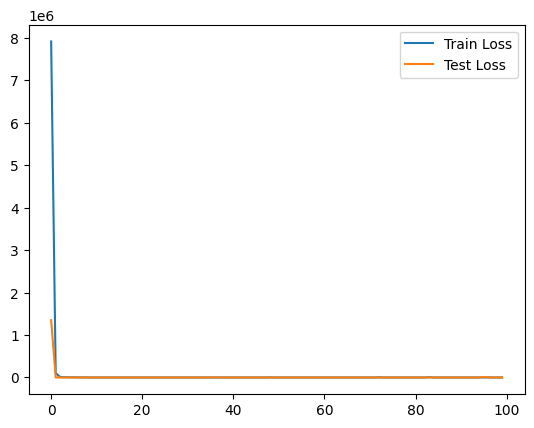

In [8]:
X_test = torch.tensor(X_test.values).float()
y_test = torch.tensor(y_test.values).float()

# Definir el tamaño del lote
batch_size = 64

# Crear un DataLoader para los datos de entrenamiento
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Crear un DataLoader para los datos de prueba
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Definir la arquitectura de la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            # nn.Linear(3, 64),
            nn.Linear(3, 16),
            nn.ReLU(),
            # nn.Linear(64, 64),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            # nn.Linear(128, 64),
            nn.Linear(16, 32),
            nn.ReLU(),
            # nn.Linear(64, 1)
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)
    
# Crear una instancia de la red neuronal
model = NeuralNetwork().to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenar la red neuronal
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")

# Visualizar la pérdida durante el entrenamiento
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [9]:
# Ver el error
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device))
    loss = criterion(y_pred, y_test.unsqueeze(1).to(device))
    print(f"Test Loss: {loss.item()}")
    print(f"Error: {loss.item() * y_train_max}")
    

Test Loss: 0.2565557360649109
Error: 256555.47950917482


In [10]:
# # Guardar el modelo
# torch.save(model.state_dict(), 'model.pth')

# # Cargar el modelo
# model = NeuralNetwork()
# model.load_state_dict(torch.load('model.pth'))
# model.eval()

# Predecir el precio de un coche
X_new = pd.DataFrame({
    'Kilómetros': [100000],
    'Edad': [4],
    'Modelo': ['SW4']
})
X_new = encoder.transform(X_new)
X_new = torch.tensor(X_new.values).float().to(device)
y_pred = model(X_new)
y_pred = y_pred.item() * y_train_max
print(f"El precio estimado del coche es: {y_pred:.2f} €")

# Predecir el precio de varios coches

El precio estimado del coche es: -121932.30 €
